<a href="https://www.kaggle.com/code/dimasjackson/supernovae-analysis-with-mcmc?scriptVersionId=113991187" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Supernovae Analysis with Markov Chain Monte Carlo

### Abstract

In this project we will use the Pantheon+SH0ES luminosity distances data of 1701 Supernovae to estimate cosmological parameters. The parameters that we are interested in are the Hubble constant $H_0$, the matter density $\Omega_m$ and the radiation density $\Omega_r$. The bayesian statistics will be adopted to calculate the posterior probability distribution of the parameters given the experimental supernovae distances, which will be used to determine the likelihood function. We will implement the emcee algorithm to generate samples with a Markov Chain Monte Carlo (MCMC) model using the posterior probability distribution. Finally, the results will be plotted in the space of parameters.

# Installing emcee

First we will install the most recently version of [emcee](https://emcee.readthedocs.io/en/stable/) library and the package Corner for corner plots. The emcee is an MIT licensed pure-Python implementation of Goodman & Weare’s Affine Invariant Markov chain Monte Carlo (MCMC) Ensemble sampler that will be used to estimate the posterior probability function. 

In [1]:
#Installing the EMCEE - Markov Chain Monte Carlo library
!pip install -U emcee

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.2/46.2 kB 404.8 kB/s eta 0:00:00


In [2]:
# Installing the Corner plot module
! python -m pip install corner

In [3]:
# Setting interative plots in the notebook from matplotlib
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [4]:
from emcee import EnsembleSampler
from emcee.backends import HDFBackend
from corner import corner
import sys

In [5]:
df = pd.read_table("/kaggle/input/supernovae-pantheonsh0es-data/PantheonSH0ES.dat", sep="\s+")

In [6]:
df.head()

,CID,IDSURVEY,zHD,zHDERR,zCMB,zCMBERR,zHEL,zHELERR,m_b_corr,m_b_corr_err_DIAG,...,PKMJDERR,NDOF,FITCHI2,FITPROB,m_b_corr_err_RAW,m_b_corr_err_VPEC,biasCor_m_b,biasCorErr_m_b,biasCor_m_b_COVSCALE,biasCor_m_b_COVADD
0,2011fe,51,0.00122,0.00084,0.00122,0.00002,0.00082,0.00002,9.74571,1.516210,...,0.1071,36,26.8859,0.864470,0.0991,1.4960,0.0381,0.005,1.0,0.003
1,2011fe,56,0.00122,0.00084,0.00122,0.00002,0.00082,0.00002,9.80286,1.517230,...,0.0579,101,88.3064,0.812220,0.0971,1.4960,-0.0252,0.003,1.0,0.004
2,2012cg,51,0.00256,0.00084,0.00256,0.00002,0.00144,0.00002,11.47030,0.781906,...,0.0278,165,233.5000,0.000358,0.0399,0.7134,0.0545,0.019,1.0,0.036
3,2012cg,56,0.00256,0.00084,0.00256,0.00002,0.00144,0.00002,11.49190,0.798612,...,0.0667,55,100.1220,0.000193,0.0931,0.7134,0.0622,0.028,1.0,0.040
4,1994DRichmond,50,0.00299,0.00084,0.00299,0.00004,0.00187,0.00004,11.52270,0.880798,...,0.0522,146,109.8390,0.988740,0.0567,0.6110,0.0650,0.009,1.0,0.006


In [7]:
df.shape

(1701, 47)

Text(0, 0.5, 'Distance Modulus')

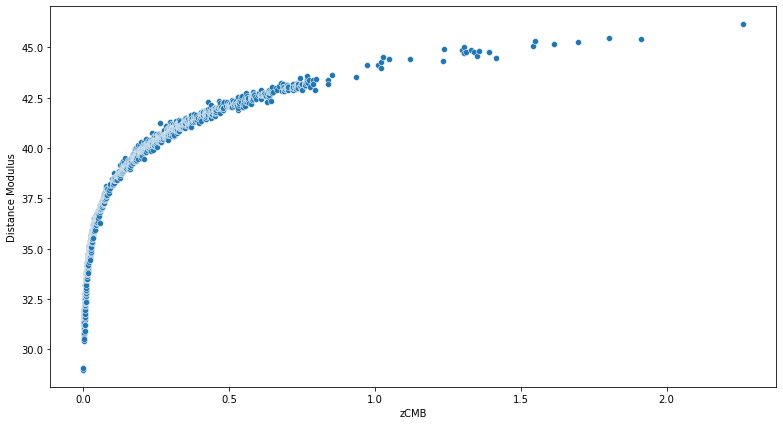

In [8]:
plt.figure(figsize=(13,7))
sns.scatterplot(x=df['zCMB'], y=df['MU_SH0ES'])
plt.xlabel("zCMB")
plt.ylabel("Distance Modulus")

# Defining the Theoretical Model

In [9]:
# Importing the numerical integration package
from scipy.integrate import quad

In [10]:
# Defining the cosmological density parameters (just our first guess)
Omega_r_guess, Omega_m_guess, H0_guess, = 9*10**(-5), 0.31, 68/(3.086*10**19) #H0 in 1 over secconds
Omega_Lambda_guess = 1-Omega_r_guess-Omega_m_guess

Our first guess to the cosmological parameters that will be estimated is:

In [11]:
print('Omega_r_guess = {:e}'.format(Omega_r_guess))
print('Omega_m_guess = {:e}'.format(Omega_m_guess))
print('H0_guess [1/s] = {:e}'.format(H0_guess))

Omega_r_guess = 9.000000e-05
Omega_m_guess = 3.100000e-01
H0_guess [1/s] = 2.203500e-18


The luminosity distance in a flat expanding Friedmann-Lemaitre-Robertson-Walker university is given by:
$$ d_L = (1+z)d_H \int_{0}^{z}dz^{\prime} \left[ \Omega_r(1+z^{\prime})^4 + \Omega_m(1+z^{\prime})^3+ \Omega_{\Lambda} \right]^{-1/2} \,,$$
where $d_H=c/H_0$ is the Hubble distance.

To calculate the luminosity distance it is necessary to perform a numerical integration

In [12]:
# The function we want to integrate
def f(z, Omega_r, Omega_m, H0):
    Omega_Lambda = 1-Omega_r-Omega_m
    return 1/(np.sqrt(Omega_r*(1+z)**4+Omega_m*(1+z)**3+Omega_Lambda))

In [13]:
# call quad to numerical integrate f using quadrature method
L=[]
for z in np.arange(0.001, 2.5, 0.0014):
    res, err = quad(f, 0, z, args=(Omega_r_guess, Omega_m_guess, H0_guess)) # I discarted the integration error, but it can be stored
    L.append(res)
len(L)

1785

In [14]:
cLight = 3*10**8 # Speed of light in vacuum
dH = cLight/H0_guess # Hubble length in Mpc

In [15]:
# Calculating the luminosity distance
z_list=[]
for z in np.arange(0.001,2.5,0.0014):
    z_list.append(z)
dL=[]
for k in np.arange(0, 1785):
    dL.append(dH*(1+z_list[k])*L[k]/(3*10**22))
print(len(z_list))
print(len(dL))

1785
1785


In [16]:
mu_model=[]
for k in range(0, 1701):
    mu_model.append((5*(np.log10(np.abs(dL[k])) + 5)))
len(mu_model)

1701

In [17]:
# The z_list array and the distance modulus must be the same length, so we will discard the remaining points
del z_list[1701:1785]
len(z_list)

1701

In [18]:
from scipy.interpolate import interp1d # Interpolation function

mu_model_inter = interp1d(z_list, mu_model, kind='cubic')


Text(0, 0.5, 'Theoretical Distance Modulus')

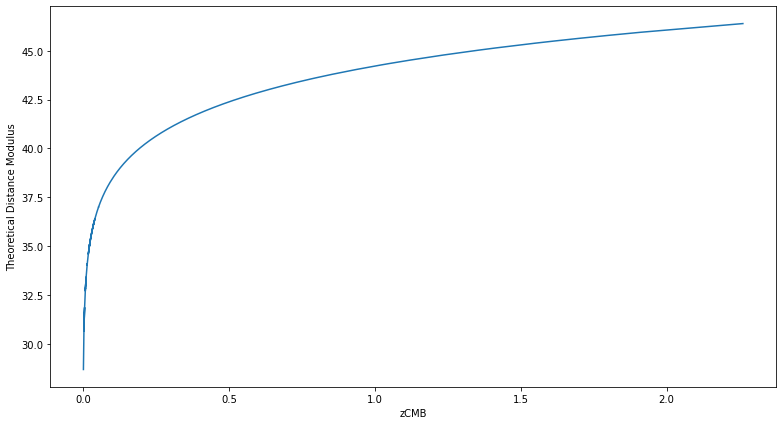

In [19]:
z_var = df['zCMB']
plt.figure(figsize=(13,7))
plt.plot(z_var, mu_model_inter(z_var))
plt.xlabel("zCMB")
plt.ylabel("Theoretical Distance Modulus")

Text(0, 0.5, 'Distance Modulus')

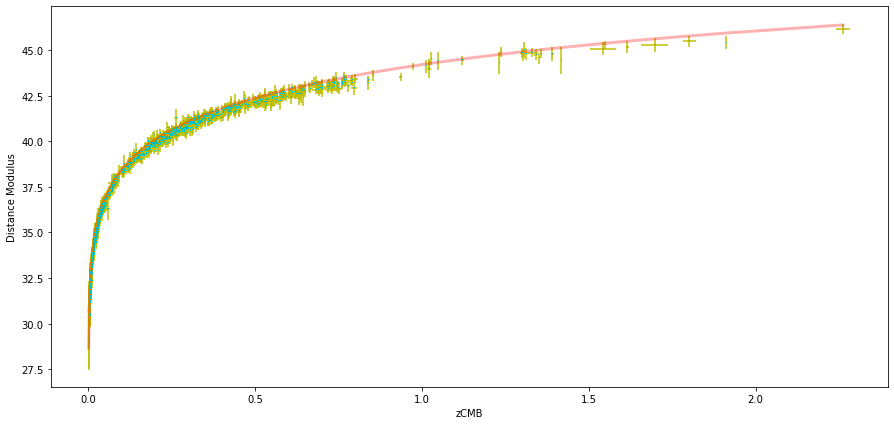

In [20]:
plt.figure(figsize=(15,7))
# Plot the error bars
x_exp=df['zCMB']
y_exp=df['MU_SH0ES']
plt.errorbar(x_exp, y_exp, xerr=df['zCMBERR'], yerr=df['MU_SH0ES_ERR_DIAG'], fmt=",c", ecolor="y", capsize=0)
# Plot the true line
y_theo=mu_model_inter
plt.plot(x_exp, y_theo(x_exp), "r", alpha=0.3, lw=3)
plt.xlabel("zCMB")
plt.ylabel("Distance Modulus")

This is a comparison between theoretical and experimental distance modulos of 1701 supernovae. The error bars comes from the Pantheon+SH0ES data, the uncertainty on MU_SH0ES was determined from the diagonal of the covariance matrix and are only for plot purpose, cannot be used to fit cosmological parameters.

# Implementing the model in a pipeline

In [21]:
def mu_model_pipe(Omega_r, Omega_m, H0):
    L=[]
    for z in np.arange(0.001, 2.5, 0.0014):
        res, err = quad(f, 0, z, args=(Omega_r, Omega_m, H0)) # I discarted the integration error, but it can be stored
        L.append(res)
    cLight = 3*10**8 # Speed of light in vacuum
    dH = cLight/H0 # Hubble length in Mpc
    # Calculating the luminosity distance
    z_list=[]
    for z in np.arange(0.001,2.5,0.0014):
        z_list.append(z)
    dL=[]
    for k in np.arange(0, 1785):
        dL.append(dH*(1+z_list[k])*L[k]/(3*10**22))
    # Calculating the distance modulus
    mu_model=[]
    for k in range(0, 1701):
        mu_model.append((5*(np.log10(np.abs(dL[k])) + 5)))
    del z_list[1701:1785]
    mu_model_inter = interp1d(z_list, mu_model, kind='cubic')
    return mu_model_inter

In [22]:
mu_test = mu_model_pipe(Omega_r_guess, Omega_m_guess, H0_guess)

Text(0, 0.5, 'Theoretical Distance Modulus')

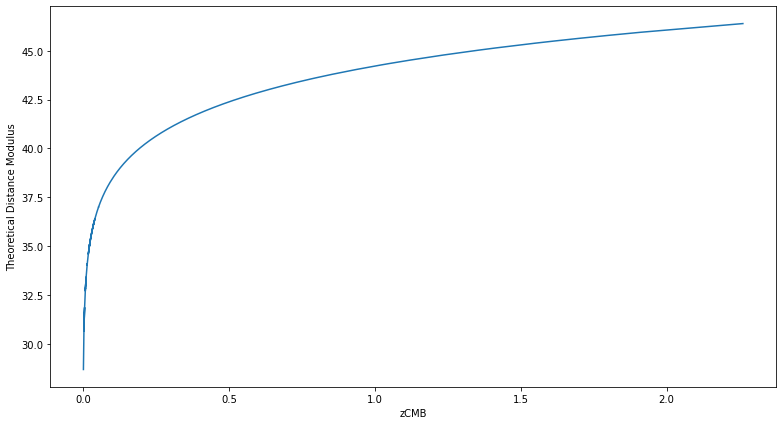

In [23]:
# Testing the mu_model_pipe function
plt.figure(figsize=(13,7))
plt.plot(z_var, mu_test(z_var))
plt.xlabel("zCMB")
plt.ylabel("Theoretical Distance Modulus")

# Importing the Covariance Matrix

The format of the covariance (.cov) file is NxN lines where the matrix should be read in sequentially.  The first line gives the number of rows/columns in the matrix (N=1701).  The STATONLY matrix has only elements that correspond to the statistical distance uncertainties for individual SNe. This includes intrinsic scatter off-diagonal components when the light-curves represent the same SN observed by different surveys.

In [24]:
cov_aux = pd.read_table('/kaggle/input/pantheon-cov-matrix/Pantheon%2BSH0ES_STAT%2BSYS.cov')
cov_aux.head()

,1701
0,0.031771
1,0.005754
2,0.000310
3,0.001187
4,0.000083


In [25]:
cov_aux.shape

(2893401, 1)

In [26]:
cov_matrix = [] # Read the covariance matrix and store in a array
for i in range(1701):
    row = []
    for j in range(1701*i,1701*(i+1)):
        row.append(cov_aux['1701'][j])
    cov_matrix.append(row)

In [27]:
len(cov_matrix)

1701

In [28]:
cov_matrix[0][0]

0.03177108

In [29]:
cov_matrix[1700][1700]==cov_aux['1701'][2893400] # Verifying if the matrix was with succes

True

In [30]:
cov_matrix = np.array(cov_matrix) # Converting the matrix list into a Numpy array format 
cov_matrix[0]

array([ 3.177108e-02,  5.754430e-03,  3.100600e-04, ...,  2.945500e-04,
       -8.595000e-05, -2.701100e-04])

In [31]:
cov_matrix.shape

(1701, 1701)

In [32]:
inv = np.linalg.inv(cov_matrix) # Calculating the inverse matrix
inv.shape

(1701, 1701)

In [33]:
inv[0] # Print the first line of the inverse

array([ 3.35405114e+01, -5.68645204e+00, -1.07870284e-01, ...,
        1.44562418e-02,  1.73619146e-02,  6.56463541e-02])

In [34]:
det = np.linalg.det(cov_matrix) # Calculates the determinant of the covariance matrix
print("%.10f" % det)

0.0000000000


In [35]:
np.linalg.eig(cov_matrix)[1] # Calculates the eigenvalues of the covariance matrix

array([[-2.96148587e-03, -2.18443140e-02,  9.91981514e-04, ...,
         9.64893133e-04,  3.19053813e-04,  5.91684316e-05],
       [-1.72476998e-03,  1.90502948e-03, -1.45654135e-02, ...,
         5.69425676e-05, -5.51999401e-04, -3.43874555e-03],
       [-3.25782834e-02,  1.53065947e-02,  1.09858778e-02, ...,
         1.54613492e-03, -1.32184742e-03, -6.56669952e-03],
       ...,
       [-2.86966100e-02, -2.16020537e-02, -1.08898760e-03, ...,
        -1.15688499e-03,  2.78073191e-04, -2.23892355e-03],
       [-4.30813218e-02,  3.33182559e-03, -2.80048267e-03, ...,
        -1.28031502e-03,  2.56683754e-04, -9.61990704e-04],
       [-5.31572832e-02,  5.55188533e-03, -9.28158623e-03, ...,
        -4.79416272e-03,  1.30874885e-03, -2.37309350e-03]])

# Likelihood Distribution Calculation

The likelihood distribution that will be used is
$$ \mathcal{L}(\mu_{\rm{exp}}, C | \theta) = 2N\pi \exp{ \left[ \frac{  -(\mu(\theta) - \mu_{\rm{exp}})^T \, C \, (\mu(\theta) - \mu_{\rm{exp}}) - \sum_{j}c_j  }{2} \right] } \,,$$
where $C$ is the covariance matrix, $c_j$ is its eigenvalues, $\theta = (\Omega_r, \Omega_m, H_0)$ and $N$ is the dimension of the data array.

In [36]:
def log_likelihood(theta, mu_data, cov):
    """Compute the Gaussian log-likelihood for a given distance modulus data, distance modulus theorical and covariance."""
    Omega_r, Omega_m, H0 = theta
    cov_inv = np.linalg.inv(cov)
    cov_eigvals = np.linalg.eig(cov)
    cov_len = len(cov)
    mu_model_array=[]
    mu_aux = mu_model_pipe(Omega_r, Omega_m, H0)
    for z in z_var:
        mu_model_array.append(mu_aux(z))
    mu_model_array=np.array(mu_model_array)
    return -0.5 * (np.matmul((mu_model_array - mu_data) , np.matmul(cov_inv , (mu_model_array - mu_data)))) - .5 * (np.sum(np.log(np.absolute(cov_eigvals[1]))) + cov_len * np.log(2*np.pi))

In [37]:
# Testing the log_likelihood:
mu_data = np.array(df['MU_SH0ES'])
cov=cov_matrix
theta = (Omega_r_guess, Omega_m_guess, H0_guess)
log_likelihood(theta, mu_data, cov)

9513506.26442485

Now, the scipy minimize function will be used to compute the parameters $\Omega_r, \Omega_m, H_0$ that optimizes the likelihood for the given data. It’s worth noting that the optimize module minimizes functions whereas we would like to maximize the likelihood. This goal is equivalent to minimizing the negative likelihood (or in this case, the negative log likelihood).

In [38]:
# Defining a random value to start the optimization
np.random.seed(42) # Generate a random number from 32
random_vec = np.array([10**(-5)*np.absolute(np.random.randn(3)[0]),10**(-1)*np.absolute(np.random.randn(3)[1]),10**(-19)*np.absolute(np.random.randn(3)[2])])
initial = np.array([Omega_r_guess, Omega_m_guess, H0_guess]) - random_vec 
initial

array([8.50328585e-05, 2.86584663e-01, 2.15655224e-18])

In [39]:
# Define the boundary values for the parameters:
Omega_r_min = 8.5*10**(-5)
Omega_r_max = 9.5*10**(-5)
Omega_m_min = 0.25
Omega_m_max = 0.35
H0_min = 65/(3.086*10**19) #H0 in 1 over secconds
H0_max = 70/(3.086*10**19) #H0 in 1 over secconds

theta_min = (Omega_r_min,Omega_m_min,H0_min)
theta_max = (Omega_r_max,Omega_m_max,H0_max)

bnds = (theta_min, theta_max)

print(bnds)

((8.5e-05, 0.25, 2.1062864549578744e-18), (9.5e-05, 0.35, 2.268308489954634e-18))


In [40]:
from scipy.optimize import Bounds
bd = Bounds(lb=theta_min, ub=theta_max)
bd

Bounds(array([8.50000000e-05, 2.50000000e-01, 2.10628645e-18]), array([9.50000000e-05, 3.50000000e-01, 2.26830849e-18]))

**This step may take a few minutes!**

In [41]:
from scipy.optimize import minimize # Minimization of scalar function

mu_data = np.array(df['MU_SH0ES']) # Load the experimental data for distance modulus
cov = cov_matrix

nll = lambda *args: -log_likelihood(*args) # Define the negative likelihood function

# Optimize the negative likelihood
soln = minimize(nll, initial, args=(mu_data, cov), method='Nelder-Mead', bounds=bd)
Omega_r_ml, Omega_m_ml, H0_ml = soln.x # Store the parameters that optimizes the likelihood

print("Optimized likelihood estimates:")
print("Omega_r = {:e}".format(Omega_r_ml))
print("Omega_m = {:e}".format(Omega_m_ml))
print("H0 = {:e}".format(H0_ml*(3.086*10**19))) # Print H0 in km/sMpc

Optimized likelihood estimates:
Omega_r = 9.500000e-05
Omega_m = 3.500000e-01
H0 = 7.000000e+01


Text(0, 0.5, 'Distance Modulus')

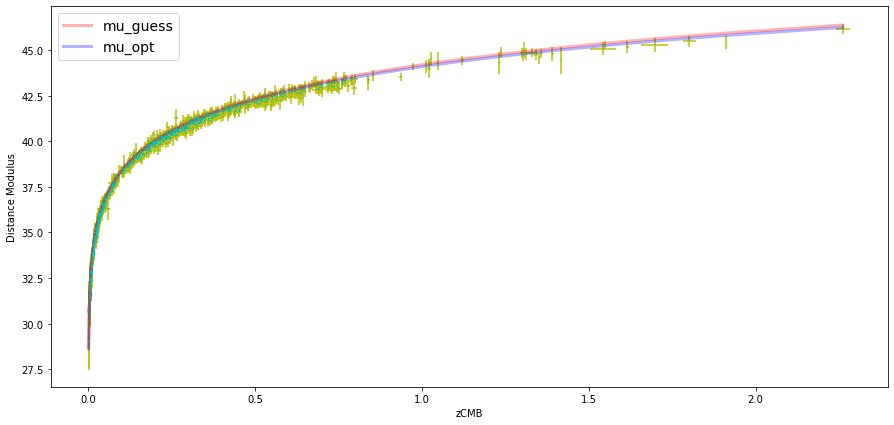

In [42]:
plt.figure(figsize=(15,7))

# Plot the error bars
x_exp=df['zCMB']
y_exp=df['MU_SH0ES']
plt.errorbar(x_exp, y_exp, xerr=df['zCMBERR'], yerr=df['MU_SH0ES_ERR_DIAG'], fmt=",c", ecolor="y", capsize=0)

# Plot the theoretical model with guess parameters
mu_guess=mu_model_pipe(Omega_r_guess, Omega_m_guess, H0_guess)
plt.plot(z_var, mu_guess(x_exp), "r", alpha=0.3, lw=3, label="mu_guess")

# Plot the theoretical model with optimized parameters
mu_opt = mu_model_pipe(Omega_r_ml, Omega_m_ml, H0_ml)
plt.plot(z_var, mu_opt(z_var), "b", alpha=0.3, lw=3, label="mu_opt")
plt.legend(fontsize=14)
plt.xlabel("zCMB")
plt.ylabel("Distance Modulus")

# Posterior Probability Function

In this section we will sample the posterior probability using the algorithm EMCEE to implement the Markov Chain Monte Carlo method. According to Bayes Theorem, the posterior probability is given by:
$$  p(\theta|\vec{x}) \propto p(\theta)\mathcal{L}(\vec{x}|\theta)\,, $$

where $\theta$ is the cosmological parameters vector, $\vec{x}$ the input data and $\mathcal{L}(\vec{x}|\theta)$ is the likelihood function.

In [43]:
# Defining the prior probability function

def log_prior(theta):
    Omega_m, Omega_r, H0 = theta # Initial parameters guess
    if 8.5*10**(-5) < Omega_r < 9.5*10**(-5) and 0.25 < Omega_m < 0.35 and 60/(3*10**19) < H0 < 75/(3*10**19):
        return 0.0
    return -np.inf

In [44]:
# Defining the full log-probability function

def log_probability(theta, mu_data, cov):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, mu_data, cov)

We’ll start by initializing the walkers in a tiny Gaussian ball around the maximum likelihood result and then run 5,000 steps of MCMC.

In [45]:
# Deargpartitionfine the initial position
pos = soln.x + [1e-7, 1e-3, 1e-20]*np.random.randn(2000, 3)
nwalkers, ndim = pos.shape
pos

array([[9.50542560e-05, 3.49536582e-01, 2.26365119e-18],
       [9.50241962e-05, 3.48086720e-01, 2.25105931e-18],
       [9.49437712e-05, 3.48987169e-01, 2.27145096e-18],
       ...,
       [9.48885919e-05, 3.49369069e-01, 2.25888789e-18],
       [9.49452004e-05, 3.49785850e-01, 2.27668003e-18],
       [9.49678841e-05, 3.48414374e-01, 2.27970917e-18]])

In [46]:
# Generating samples with emcee
import emcee

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, args=(mu_data, cov))
sampler.run_mcmc(pos, 10000, progress=True);

  0%|          | 0/10000 [00:00<?, ?it/s]/opt/conda/lib/python3.7/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
100%|██████████| 10000/10000 [03:04<00:00, 54.17it/s]


# Plotting the Parameters Estimatitive

About 40 steps are needed for the chain to “forget” where it started. Let’s discard the initial 100 steps, thin by about 15 steps, and flatten the chain so that we have a flat list of samples:

In [47]:
# get_chain attribute from EnsembleSampler emcee:
# flat – Flatten the chain across the ensemble. (default: False)
# thin – Take only every thin steps from the chain. (default: 1)
# discard – Discard the first discard steps in the chain as burn-in. (default: 0)
flat_samples = sampler.get_chain(discard=100, thin=15, flat=True)
labels = ["\Omega_r", "\Omega_m", "H_0[1/s]"]

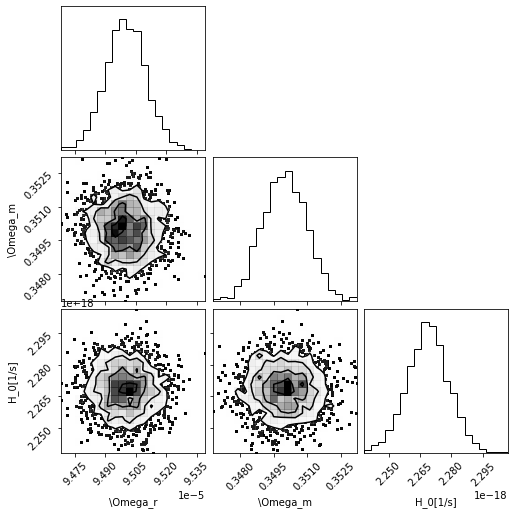

In [48]:
import corner

fig = corner.corner(
    flat_samples, labels=labels, truths=[Omega_m_guess, Omega_r_guess, H0_guess]
);

The corner plot shows the marginalized distribution for each parameter independently in the histograms along the diagonal and then the marginalized two dimensional distributions in the other panels.

In [49]:
#Given a vector V of length N, the q-th percentile of V is the value q/100 of the way from the minimum to the maximum in a sorted copy of V
aux = []
for i in range(ndim):
    aux.append(np.percentile(flat_samples[:, i], [16, 50, 84])) # Compute the 16-th, 50-th and 84-th percentile of the data along the specified axis.
aux

[array([9.49006059e-05, 9.49979267e-05, 9.50966047e-05]),
 array([0.34896704, 0.34997309, 0.35095527]),
 array([2.25882410e-18, 2.26865838e-18, 2.27861148e-18])]

In [50]:
mcmc = np.array([aux[0], aux[1], aux[2]*(3.086*10**19)])
mcmc

array([[9.49006059e-05, 9.49979267e-05, 9.50966047e-05],
       [3.48967041e-01, 3.49973087e-01, 3.50955275e-01],
       [6.97073117e+01, 7.00107975e+01, 7.03179503e+01]])

In [51]:
from IPython.display import display, Math

for i in range(ndim):
    q = np.diff(mcmc[i]) # Calculate the n-th discrete difference along the given axis: a[i+1] - a[i]
    labels2 = ["\Omega_r", "\Omega_m", "H_0[km/sMpc]"]
    txt = "\mathrm{{{3}}} = {0:.9f}_{{-{1:.8f}}}^{{+{2:.8f}}}"
    txt = txt.format(mcmc[i][1], q[0], q[1], labels2[i])
    display(Math(txt))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

**These are the final values estimated by the ensemble sampler emcee for the radiation density $\Omega_r$, the mass density $\Omega_r$ and the Hubble parameter $H_0$.**